# NOTEBOOK FOR DEFAULT LRG - PICKLE FILES

In [1]:
# Import the necessary packages and set up the fiducial cosmology
import os
import pickle
import numpy as np
import scipy as sp
import pandas as pd
from astropy.io import ascii
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev
from cosmoprimo import PowerSpectrumBAOFilter
from cosmoprimo.fiducial import DESI
from pypower import BaseMatrix, CatalogFFTPower, CatalogFFTCorr, PowerSpectrumMultipoles, PowerSpectrumSmoothWindow, PowerSpectrumSmoothWindowMatrix, PowerSpectrumOddWideAngleMatrix, setup_logging
from pycorr import TwoPointCorrelationFunction, project_to_multipoles
cosmo = DESI()
print(cosmo["Omega_b"]*cosmo["h"]**2, cosmo["Omega_cdm"]*cosmo["h"]**2, cosmo["Omega_m"]*cosmo["h"]**2 - cosmo["Omega_b"]*cosmo["h"]**2)
print(cosmo["ln10^10A_s"], cosmo["n_s"], cosmo["tau_reio"])
print(np.sum(cosmo["m_ncdm"]))

# Save the default DESI template to a file
k_min = 1e-4
k_max = 5
k_num = 2000
kl = np.logspace(np.log(k_min), np.log(k_max), k_num, base=np.e)
pkz = cosmo.get_fourier().pk_interpolator()
pk = pkz.to_1d(z=0)
pkv = pk(kl)
pknow = PowerSpectrumBAOFilter(pk, engine='wallish2018').smooth_pk_interpolator()
pksmv = pknow(kl)
# np.savetxt("./DESI_Pk_template.dat", np.c_[kl, pksmv, pkv/pksmv - 1.0],  fmt="%g %g %g", header="k     pk_smooth     pk_ratio")

# A useful sort function for Christoph's files.
def sortfunc_cs(item):
    if "EZmock" in item:
        if "CubicBox" in item:
            return int(item.split("_")[1][4:-4])
        else:
            return int(item.split("_")[3][:-4])
    else:
        if "CubicBox" in item:
            return int(item.split("_")[3][:-4])
        else:
            return int(item.split("_")[1][-3:])

# A useful sort function for Sesh's files.
def sortfunc_sn(item):
    if "EZmock" in item:
        if "CubicBox" in item:
            return int(item.split("_")[1][4:-4])
    else:
        if "CubicBox" in item:
            return int(item.split("_")[3][2:5])
        else:
            return int(item.split("_")[4][2:5])
        
# A useful sort function for Daniel's files.
def sortfunc_dfs(item):
    if "EZmock" in item:
        if "CubicBox" in item:
            return int(item.split("_")[4][4:-4])
    else:
        if "CubicBox" in item:
            return int(item.split("_")[3][2:5])
        else:
            return int(item.split("_")[4][2:5])
        
# A useful sort function for Daniel's files.
def sortfunc_dfs(item):
    if "EZmock" in item:
        if "CubicBox" in item:
            return int(item.split("_")[4][4:-4])
    else:
        if "CubicBox" in item:
            return int(item.split("_")[3][2:5])
        else:
            return int(item.split("_")[4][2:5])
        
# A useful sort function for Boryana's files.
def sortfunc_bh(item):
    if "EZmock" in item:
        if "CubicBox" in item:
            return int(item.split("_")[4][4:-4])
    else:
        if "CubicBox" in item:
            return int(item.split("_")[3][2:5])
        else:
            return int(item.split("_")[4][2:5])
        
# A useful sort function for Cristhian's files.
def sortfunc_cgq(item):
    if "EZmock" in item:
        if "CubicBox" in item:
            return int(item.split("_")[4][4:-4])
    else:
        if "CubicBox" in item:
            return int(item.split("_")[2][2:5])
        else:
            return int(item.split("_")[4][2:5])
        
# A useful sort function for Cristhian's files.
def sortfunc_x(item):
    if "EZmock" in item:
        if "CubicBox" in item:
            return int(item.split("_")[4][4:-4])
    else:
        if "CubicBox" in item:
            return int(item.split("_")[9][5:8])
        else:
            return int(item.split("_")[4][2:5])


0.02237 0.12 0.1206441345126498
3.0363942552728806 0.9649 0.0544
0.05999991930682943


# Power spectrum routines

In [2]:
# Power Spectrum. Juan Mena Fernández style where everything is put into single files per multipole. Barry needs 5 even+odd multipoles, but the odd ones can be filled with zeros if these haven't been measured, as is done here.
def getpk(loc, zname):
    kin = pd.read_csv(loc+"/k.txt", comment="#", skiprows=0, delim_whitespace=True, header=None).to_numpy().T[0]
    pkmat = [pd.read_csv(loc+f"/Pk_{ell}"+zname+".txt", comment="#", skiprows=0, delim_whitespace=True, header=None).to_numpy().T for ell in [0,2,4]]

    # Overwrite the <k> with the bin centres as we now use a binning matrix to correct to <P(k)>
    kin = np.linspace(0.0, 0.5, 100, endpoint=False) + 0.0025
    
    res = []
    nmocks = np.shape(pkmat[0])[0]
    for i in range(nmocks):
        df = {}
        df["k"] = kin
        for l, ell in enumerate([0, 2, 4]):
            df[f"pk{ell}"] = pkmat[l][i]
        df["pk1"] = np.zeros(len(df["k"]))
        df["pk3"] = np.zeros(len(df["k"]))
        res.append(pd.DataFrame(df)[["k", "pk0", "pk1", "pk2", "pk3", "pk4"]])
        
    return res


# Power Spectrum, Sesh Nadathur style where we read in the .npy files. Barry needs 5 even+odd multipoles, but the odd ones can be filled with zeros if these haven't been measured, as is done here.
# Forces the k-values to be the same between pre- and post-recon if they are available as this is needed to align the window function.
def getpk_sn(loc, zname, ks=None):

    rebinfactor = 1
    
    files = [loc + f for f in os.listdir(loc) if zname in f and ".npy" in f]
    if "CubicBox" in files[0] and "LRG" in files[0]:
         files = [f for f in files if "b2.35" in f]
    files.sort(key=sortfunc_sn)
        
    # Overwrite the <k> with the bin centres as we now use a binning matrix to correct to <P(k)>
    ks = np.linspace(0.0, 0.5, 100, endpoint=False) + 0.0025
    
    res = []
    for f in files:
        data = PowerSpectrumMultipoles.load(f)
        data.slice(slice(0,100,1))
        data.rebin(rebinfactor)
        df = pd.DataFrame(np.vstack(data(ell=[0,2,4], return_k=True)).T.real, columns=["k", "pk0", "pk2", "pk4"])
        df["pk1"] = np.zeros(len(df["k"]))
        df["pk3"] = np.zeros(len(df["k"]))
        df["nk"] = data.nmodes
        if ks is not None:
            df["k"] = ks
        res.append(df[["k", "pk0", "pk1", "pk2", "pk3", "pk4"]])
    return res
     
# Power Spectrum, Cristhian Garcia-Quintero style where we read in the .npy files. Barry needs 5 even+odd multipoles, but the odd ones can be filled with zeros if these haven't been measured, as is done here.
# Forces the k-values to be the same between pre- and post-recon if they are available as this is needed to align the window function.
def getpk_cgq(loc, zname, ks=None):

    rebinfactor = 1
    
    files = [loc + f for f in os.listdir(loc) if zname in f and ".npy" in f]
    files.sort(key=sortfunc_cgq)
                
    # Overwrite the <k> with the bin centres as we now use a binning matrix to correct to <P(k)>
    ks = np.linspace(0.0, 0.5, 100, endpoint=False) + 0.0025
        
    res = []
    for f in files:
        data = CatalogFFTPower.load(f).poles
        data.slice(slice(0,100,1))
        data.rebin(rebinfactor)
        df = pd.DataFrame(np.vstack(data(ell=[0,2,4], return_k=True)).T.real, columns=["k", "pk0", "pk2", "pk4"])
        df["pk1"] = np.zeros(len(df["k"]))
        df["pk3"] = np.zeros(len(df["k"]))
        df["nk"] = data.nmodes
        if ks is not None:
            df["k"] = ks
        res.append(df[["k", "pk0", "pk1", "pk2", "pk3", "pk4"]])
    return res

# Power Spectrum, Xinyi style where we read in the .npy files. Barry needs 5 even+odd multipoles, but the odd ones can be filled with zeros if these haven't been measured, as is done here.
# Forces the k-values to be the same between pre- and post-recon if they are available as this is needed to align the window function.
def getpk_x(loc, zname, ks=None):

    rebinfactor = 1
    
    files = [loc + f for f in os.listdir(loc) if zname in f and ".npy" in f]
    files.sort(key=sortfunc_x)
                
    # Overwrite the <k> with the bin centres as we now use a binning matrix to correct to <P(k)>
    ks = np.linspace(0.0, 0.5, 100, endpoint=False) + 0.0025
        
    res = []
    for f in files:
        data = CatalogFFTPower.load(f).poles
        data.slice(slice(0,100,1))
        data.rebin(rebinfactor)
        df = pd.DataFrame(np.vstack(data(ell=[0,2,4], return_k=True)).T.real, columns=["k", "pk0", "pk2", "pk4"])
        df["pk1"] = np.zeros(len(df["k"]))
        df["pk3"] = np.zeros(len(df["k"]))
        df["nk"] = data.nmodes
        if ks is not None:
            df["k"] = ks
        res.append(df[["k", "pk0", "pk1", "pk2", "pk3", "pk4"]])
    return res

# Power Spectrum. Pat Macdonald ICs style, where we have already written a new file combining the dd, de and ee terms given a value for bias and f
def getpk_pm(loc, zname):
        
    kin = np.load(loc + '/ks_for_P_576.npy')
    pkmat = np.load('./ic_LRG_pk_25.npy').T
    print(np.shape(pkmat))
    
    # Overwrite the <k> with the bin centres as we now use a binning matrix to correct to <P(k)>
    kin = np.linspace(0.0, 0.5, 100, endpoint=False) + 0.0025
    
    res = []
    nmocks = np.shape(pkmat[0])[0]
    print(nmocks)
    for i in range(nmocks):
        df = {}
        df["k"] = kin
        index = np.where(df["k"] < 0.5)
        df["k"] = df["k"][index]
        df["pk1"] = np.zeros(len(df["k"]))
        df["pk3"] = np.zeros(len(df["k"]))
        for l, ell in enumerate([0, 2, 4]):
            df[f"pk{ell}"] = pkmat[i][l][index]
        print(pd.DataFrame(df))
        res.append(pd.DataFrame(df)[["k", "pk0", "pk1", "pk2", "pk3", "pk4"]])
        
    return res

# Power Spectrum, Daniel Forero-Sanchez style where each power spectrum file is in it's own directory. Barry needs 5 even+odd multipoles, but the odd ones can be filled with zeros if these haven't been measured, as is done here.
# Forces the k-values to be the same between pre- and post-recon if they are available as this is needed to align the window function.
def getpk_dfs(loc, zname, ks=None):

    rebinfactor = 1
    
    files = [loc + f + "/sym_pk.pkl.npy" for f in os.listdir(loc)]
    files.sort(key=sortfunc_dfs)

    # Overwrite the <k> with the bin centres as we now use a binning matrix to correct to <P(k)>
    kin = np.linspace(0.0, 0.5, 100, endpoint=False) + 0.0025
                
    res = []
    for f in files:
        data = CatalogFFTPower.load(f).poles
        data.slice(slice(0,100,1))
        data.rebin(rebinfactor)
        df = pd.DataFrame(np.vstack(data(ell=[0,2,4], return_k=True)).T.real, columns=["k", "pk0", "pk2", "pk4"])
        df["pk1"] = np.zeros(len(df["k"]))
        df["pk3"] = np.zeros(len(df["k"]))
        df["nk"] = data.nmodes
        if ks is not None:
            df["k"] = ks
        res.append(df[["k", "pk0", "pk1", "pk2", "pk3", "pk4"]])
    return res

# Power Spectrum, Boryana Hadzhiyska style where each power spectrum file is a csv to be read in using astropy and both pre- and post-recon are in teh directory. Barry needs 5 even+odd multipoles, but the odd ones can be filled with zeros if these haven't been measured, as is done here.
# Forces the k-values to be the same between pre- and post-recon if they are available as this is needed to align the window function.
def getpk_bh(loc, zname, ks=None):
    
    files = [loc + f for f in os.listdir(loc) if 'snap' in f and 'reciso' not in f]
    print(files)
    files.sort(key=sortfunc_bh)

    # Overwrite the <k> with the bin centres as we now use a binning matrix to correct to <P(k)>
    kin = np.linspace(0.0, 0.5, 100, endpoint=False) + 0.0025
    
    res = []
    for f in files:
        print(f)
        data = ascii.read(f)
        df = pd.DataFrame(data['kmid'])
        df["k"] = df["kmid"]
        df["pk0"] = data["P0(k)_CV"]
        df["pk1"] = np.zeros(len(df["k"]))
        df["pk2"] = data["P2(k)_CV"]
        df["pk3"] = np.zeros(len(df["k"]))
        df["pk4"] = data["P4(k)_CV"]
        df["nk"] = data["nmodes"]
        df = df.drop(df[df["k"] >= 0.5].index)
        if ks is not None:
            df["k"] = ks
        res.append(df[["k", "pk0", "pk1", "pk2", "pk3", "pk4"]])
    return res

# Window function matrix. The window functions are stored in a dictionary of 'step sizes' i.e., how many bins get stuck together relative to the 
# pk measurements so that we can rebin the P(k) at run time if required. Each step size is a dictionary with:
#    the input and output k binning (w_ks_input, w_ks_output), the window function matrix (w_transform) and integral constraint (w_k0_scale).
# The window function assumes 6 input and 5 output multipoles. For cubic sims, we can set the integral constraint to zero and window matrix to a binning matrix, as is done here.
def getwin_dummy(ks):
    
    dk = ks[1] - ks[0]
    ks_input = np.logspace(-3.0, np.log10(0.5), 500)

    binmat = np.zeros((len(ks), len(ks_input)))
    for ii in range(len(ks_input)):

        # Define basis vector
        pkvec = np.zeros_like(ks_input)
        pkvec[ii] = 1

        # Define the spline:
        pkvec_spline = splrep(ks_input, pkvec)

        # Now compute binned basis vector:
        tmp = np.zeros_like(ks)
        for i, kk in enumerate(ks):
            kl = kk - dk / 2
            kr = kk + dk / 2
            kin = np.linspace(kl, kr, 100)
            tmp[i] = np.trapz(kin**2 * splev(kin, pkvec_spline, ext=3), x=kin) * 3 / (kr**3 - kl**3)

        binmat[:, ii] = tmp

    plt.imshow(binmat)
    plt.show()

    w_transform = np.zeros((5 * ks.size, 6 * ks_input.size))
    for i in range(5):
        w_transform[i*ks.size: (i+1)*ks.size , i*ks_input.size : (i+1)*ks_input.size] = binmat
    
    # The conversion matrix M from Beutler 2019. Used to compute the odd multipole models given the even multipoles. In the absence of wide angle effects, or if we don't care about
    # the odd multipoles, we can set this to a block matrix with identity matrices in the appropriate places, as is done here.
    matrix = np.zeros((6 * ks_input.size, 3 * ks_input.size))
    matrix[: ks_input.size, : ks_input.size] = np.diag(np.ones(ks_input.size))
    matrix[2 * ks_input.size : 3 * ks_input.size, ks_input.size : 2 * ks_input.size] = np.diag(np.ones(ks_input.size))
    matrix[4 * ks_input.size : 5 * ks_input.size, 2 * ks_input.size :] = np.diag(np.ones(ks_input.size))
    
    res = {"w_ks_input": ks_input, "w_k0_scale": np.zeros(ks.size), "w_transform": w_transform, "w_ks_output": ks}
    return {1: res}, matrix  # Step size is one


# Read's in Juan's k-space window multipoles and use the routines in pypower to convert these to window and wideangle matrices
def getwin(ks, winfile):
    
    wa_orders = 1 # wide-angle order
    ellsin = [0, 2, 4] # input (theory) multipoles
    ellsout = [0, 1, 2, 3, 4] # output multipoles
    
    # Check for the presence of window and wide angle matrix files already. If we find both, just load them in
    winmatname = winfile + "_matrix.npy"
    wideanglename = winfile + "_wideangle.npy"
    if os.path.exists(winmatname) and os.path.exists(wideanglename):
    
        wm = BaseMatrix.load(winmatname)
        wam = BaseMatrix.load(wideanglename)
        
    else:

        window = PowerSpectrumSmoothWindow.load(winfile + ".npy")

        sep = np.geomspace(1e-4, 1e4, 1024*16) # configuration space separation for FFTlog
        kin_rebin = 8 # rebin input theory to save memory, and run time when fitting.
        kin_lim = (1e-4, 0.4) # pre-cut input (theory) ks to save some memory
        projsin = ellsin + PowerSpectrumOddWideAngleMatrix.propose_out(ellsin, wa_orders=wa_orders)
        wm = PowerSpectrumSmoothWindowMatrix(ks, projsin=projsin, projsout=ellsout, window=window, sep=sep, kin_rebin=kin_rebin, kin_lim=kin_lim, default_zero=True)
        wam = PowerSpectrumOddWideAngleMatrix(wm.xin[0], projsin=ellsin, projsout=wm.projsin, d=1., wa_orders=wa_orders, los=window.attrs['los_type'])
        
        # Save the matrices
        wm.save(winmatname)
        wam.save(wideanglename)
        # The pypower functions store the inner chunks in the order 0, 2, 4, 1, 3, 5, 
        # but Barry expects 0, 1, 2, 3, 4, 5. So let's break the matrices apart and reorder them.
        wm_reshape = np.vsplit(wm.value, 6)
        wm_reshape = np.concatenate([wm_reshape[0],wm_reshape[3],wm_reshape[1],wm_reshape[4],wm_reshape[2],wm_reshape[5]]).T    
        wam_reshape = np.hsplit(wam.value, 6)
        wam_reshape = np.concatenate([wam_reshape[0],wam_reshape[3],wam_reshape[1],wam_reshape[4],wam_reshape[2],wam_reshape[5]], axis=1).T

        res = {"w_ks_input": wm.xin[0], "w_k0_scale": np.zeros(ks.size), "w_transform": wm_reshape, "w_ks_output": wm.xout[0]}
        winmat = {1: res}   # Step size is one, but we could modify this to contain other stepsizes too.

        return winmat, wam_reshape
    
# Power spectrum covariance matrix. Needs to have 6 multipoles, but if the some of them haven't been measured, we can set the covariance matrix elements to the identity matrix, as is done here.
def format_pk_cov(nks, covfile, covformat="jmf", zname=None):

    if covformat == "jmf":
        cov_input = pd.read_csv(covfile, comment="#", delim_whitespace=True, header=None).to_numpy()        
        nin = nks
        cov = np.eye(5 * nks)
        cov[:nks, :nks] = cov_input[:nks, :nks]
        cov[:nks, 2 * nks : 3 * nks] = cov_input[:nks, nin : nin + nks]
        cov[:nks, 4 * nks : 5 * nks] = cov_input[:nks, 2 * nin : 2 * nin + nks]
        cov[2 * nks : 3 * nks, :nks] = cov_input[nin : nin + nks, :nks]
        cov[2 * nks : 3 * nks, 2 * nks : 3 * nks] = cov_input[nin : nin + nks, nin : nin + nks]
        cov[2 * nks : 3 * nks, 4 * nks : 5 * nks] = cov_input[nin : nin + nks, 2 * nin : 2 * nin + nks]
        cov[4 * nks : 5 * nks, :nks] = cov_input[2 * nin : 2 * nin + nks, :nks]
        cov[4 * nks : 5 * nks, 2 * nks : 3 * nks] = cov_input[2 * nin : 2 * nin + nks, nin : nin + nks]
        cov[4 * nks : 5 * nks, 4 * nks : 5 * nks] = cov_input[2 * nin : 2 * nin + nks, 2 * nin : 2 * nin + nks]
    else:
        pks = getpk_dfs(covfile, zname)
        cov = np.cov(np.array([np.concatenate([df["pk0"], df["pk1"], df["pk2"], df["pk3"], df["pk4"]]) for df in pks]).T)
        cov[nks:2*nks, nks:2*nks] = np.eye(nks)
        cov[3*nks:4*nks, 3*nks:4*nks] = np.eye(nks)
            
    plt.imshow(cov/np.sqrt(np.outer(np.diag(cov), np.diag(cov))))
    plt.show()
            
    # Check the covariance matrix is invertible
    v = np.diag(cov @ np.linalg.inv(cov))
    if not np.all(np.isclose(v, 1)):
        print("ERROR, setting an inappropriate covariance matrix that is almost singular!!!!")
        #print(f"These should all be 1: {v}")
    
    return cov

# Pat's analytic covariance matrix
def format_pk_analytic(nks, covfile):

    cov_input = np.load(covfile)
    nin = np.shape(cov_input)[2]
    cov = np.eye(5 * nks)
    cov[:nin, :nin] = cov_input[0,0]
    cov[:nin, 2 * nks : 2 * nks + nin] = cov_input[0,1]
    cov[:nin, 4 * nks : 4 * nks + nin] = cov_input[0,2]
    cov[2 * nks : 2 * nks + nin, :nin] = cov_input[1,0]
    cov[2 * nks : 2 * nks + nin, 2 * nks : 2 * nks + nin] = cov_input[1,1]
    cov[2 * nks : 2 * nks + nin, 4 * nks : 4 * nks + nin] = cov_input[1,2]
    cov[4 * nks : 4 * nks + nin, :nin] = cov_input[2,0]
    cov[4 * nks : 4 * nks + nin, 2 * nks : 2 * nks + nin] = cov_input[2,1]
    cov[4 * nks : 4 * nks + nin, 4 * nks : 4 * nks + nin] = cov_input[2,2]
    
    # Check the covariance matrix is invertible
    v = np.diag(cov @ np.linalg.inv(cov))
    if not np.all(np.isclose(v, 1)):
        print("ERROR, setting an inappropriate covariance matrix that is almost singular!!!!")
        #print(f"These should all be 1: {v}")
    
    return cov

# Useful utility function to collate some Pk data
def collect_pk_data(pre_files, post_files, pre_cov_files, post_cov_files, winfile, zeff, prezname, postzname, name, preformat="jmf", postformat="jmf", precovformat="jmf", postcovformat="jmf"):
    
    ks = None
    pre_cov, post_cov = None, None
    pre_data, post_data = None, None
    pre_mocks, post_mocks = None, None
    if pre_files is not None:
        if preformat=="jmf": 
            pre_res = getpk(pre_files, prezname) 
        elif preformat=="pm":
            pre_res = getpk_pm(pre_files, prezname) 
        elif preformat == "bh":
            pre_res = getpk_bh(pre_files, prezname)
        elif preformat == "cgq":
            pre_res = getpk_cgq(pre_files, prezname)
        elif preformat == "x":
            pre_res = getpk_x(pre_files, prezname)
        else:
            pre_res = getpk_sn(pre_files, prezname)
        ks = pre_res[0]["k"].to_numpy()
        pre_cov = format_pk_cov(len(ks), pre_cov_file) if precovformat=="jmf" else format_pk_analytic(len(ks), pre_cov_file)
        pre_mocks = [v for v in pre_res]
    if post_files is not None:
        if postformat=="jmf": 
            post_res = getpk(post_files, postzname, ks=ks)
        elif postformat=="pm":
            post_res = getpk_pm(post_files, postzname, ks=ks)
        elif postformat == "bh":
            post_res = getpk_bh(post_files, postzname, ks=ks)
        elif postformat == "cgq":
            post_res = getpk_cgq(post_files, postzname, ks=ks)
        elif postformat == "x":
            post_res = getpk_x(post_files, postzname, ks=ks)
        else:
            post_res = getpk_sn(post_files, postzname, ks=ks)
        ks = post_res[0]["k"].to_numpy()
        post_cov = format_pk_cov(len(ks), post_cov_file, postcovformat, zname=postzname) if postcovformat=="jmf" or postcovformat=="dfs" else format_pk_analytic(len(ks), pre_cov_file)
        post_mocks = [v for v in post_res]
        
        print(ks)

        if winfile is not None:
            winmat, wideangle = getwin(ks, winfile)
        else:
            winmat, wideangle = getwin_dummy(ks)

        split = {
            "n_data": 1,
            "pre-recon data": pre_data,
            "pre-recon cov": pre_cov,
            "post-recon data": post_data,
            "post-recon cov": post_cov,
            "pre-recon mocks": pre_mocks,
            "post-recon mocks": post_mocks,
            "cosmology": {
                "om": cosmo["Omega_m"],
                "h0": cosmo["h"],
                "z": zeff,
                "ob": cosmo["Omega_b"],
                "ns": cosmo["n_s"],
                "mnu": np.sum(cosmo["m_ncdm"]),
                "reconsmoothscale": 10,
            },
            "name": name,
            "winfit": winmat,
            "winpk": None,  # We can set this to None; Barry will set it to zeroes given the length of the data vector.
            "m_mat": wideangle,
        }

        with open(f"../" + name.lower().replace(" ", "_")+".pkl", "wb") as f:
            pickle.dump(split, f)
            print(f)
        return split
    
    
# Plot the power spectra, for sanity checking
def plot_pk(split, pre=True, post=True):
    
    if pre:
        color = ["r", "b", "g"]
        ks = split["pre-recon mocks"][0]["k"]
        nmocks = len(split["pre-recon mocks"])
        label = [r"$P_{0}(k)$", r"$P_{2}(k)$", r"$P_{4}(k)$"]
        for m, pk in enumerate(["pk0", "pk2", "pk4"]):
            yerr = ks * np.sqrt(np.diag(split["pre-recon cov"]))[2 * m * len(ks) : (2 * m + 1) * len(ks)]
            plt.errorbar(
                ks,
                ks * np.mean([split["pre-recon mocks"][i][pk] for i in range(nmocks)], axis=0),
                yerr=yerr,
                marker="o",
                ls="None",
                c=color[m],
                label=label[m],
            )
            for i in range(nmocks):
                plt.errorbar(ks, ks * split["pre-recon mocks"][i][pk], marker="None", ls="-", c='k', alpha=1.0 / nmocks**(3.0/4.0))
        plt.xlabel(r"$k$")
        plt.ylabel(r"$k\,P(k)$")
        plt.title(split["name"] + " Prerecon")
        plt.legend(loc='upper right')
        plt.show()   
    if post:
        color = ["r", "b", "g"]
        ks = split["post-recon mocks"][0]["k"]
        nmocks = len(split["post-recon mocks"])
        label = [r"$P_{0}(k)$", r"$P_{2}(k)$", r"$P_{4}(k)$"]
        for m, pk in enumerate(["pk0", "pk2", "pk4"]):
            yerr = ks * np.sqrt(np.diag(split["post-recon cov"]))[2 * m * len(ks) : (2 * m + 1) * len(ks)]
            plt.errorbar(
                ks,
                ks * np.mean([split["post-recon mocks"][i][pk] for i in range(nmocks)], axis=0),
                yerr=yerr,
                marker="o",
                ls="None",
                c=color[m],
                label=label[m],
            )
            for i in range(nmocks):
                plt.errorbar(ks, ks * split["post-recon mocks"][i][pk], marker="None", ls="-", c='k', alpha=1.0 / nmocks**(3.0/4.0))
        plt.xlabel(r"$k$")
        plt.ylabel(r"$k\,P(k)$")
        plt.title(split["name"] + " Postrecon")
        plt.legend(loc='upper right')
        plt.show()

# Correlation function routines

In [3]:
# Correlation function. Juan Mena Fernández style where everything is put into single files per multipole
def getxi(loc, zname):
    sin = pd.read_csv(loc+"/s.txt", comment="#", skiprows=0, delim_whitespace=True, header=None).to_numpy().T[0]
    ximat = [pd.read_csv(loc+f"/Xi_{ell}"+zname+".txt", comment="#", skiprows=0, delim_whitespace=True, header=None).to_numpy().T for ell in [0,2,4]]
        
    res = []
    nmocks = np.shape(ximat[0])[0]
    for i in range(nmocks):
        df = {}
        df["s"] = sin
        for l, ell in enumerate([0, 2, 4]):
            df[f"xi{ell}"] = ximat[l][i]
        res.append(pd.DataFrame(df))
    
    return res

# Correlation function. Christoph Saulder style, where we read in the .npy files and rebin with 4Mpc/h binning
def getxi_cs(loc, zname):
    
    rebinfactor = 4
    
    files = [loc + f for f in os.listdir(loc) if zname in f and ".npy" in f and "poles" not in f]
    files.sort(key=sortfunc_cs)
        
    res = []
    for f in files:
        data = TwoPointCorrelationFunction.load(f)
        data.rebin((rebinfactor, 1))
        df = pd.DataFrame(np.vstack(project_to_multipoles(data)).T, columns=["s", "xi0", "xi2", "xi4"])
        res.append(df)
        
    return res

# Correlation function. Pat Macdonald ICs style, where we have already written a new file combining the dd, de and ee terms given a value for bias and f
def getxi_pm(loc, zname):
        
    sin = np.load(loc + 'rs_for_xi_576_4.0_0.npy')
    ximat = np.load('./ic_LRG_xi_25.npy').T
    print(np.shape(ximat))
    
    res = []
    nmocks = np.shape(ximat[0])[0]
    print(nmocks)
    for i in range(nmocks):
        df = {}
        df["s"] = sin
        index = np.where(df["s"] < 202)
        df["s"] = df["s"][index]
        for l, ell in enumerate([0, 2, 4]):
            df[f"xi{ell}"] = ximat[i][l][index]
        print(pd.DataFrame(df))
        res.append(pd.DataFrame(df))
        
    return res

# Correlation function. Daniel Forero-Sanchez style, where we read in the .npy files and rebin with 4Mpc/h binning
def getxi_dfs(loc, zname):
    
    rebinfactor = 4
    
    files = [loc + f + "/sym_fft_tpcf.pkl.npy" for f in os.listdir(loc)]
    files.sort(key=sortfunc_dfs)
        
    res = []
    for f in files:
        data = CatalogFFTCorr.load(f).poles
        data.rebin(rebinfactor)
        df = pd.DataFrame(np.vstack(data(ell=[0,2,4], return_s=True)).T.real, columns=["s", "xi0", "xi2", "xi4"])
        res.append(df)
    return res

# Correlation function covariance matrix.
def format_xi_cov(nss, covfile, covformat="jmf", zname=None):

    if covformat == "jmf":
        cov_input = pd.read_csv(covfile, comment="#", delim_whitespace=True, header=None).to_numpy()
        nin = nss
        cov = np.zeros((3 * nss, 3 * nss))
        cov[:nss, :nss] = cov_input[:nss, :nss]
        cov[:nss, nss : 2 * nss] = cov_input[:nss, nin : nin + nss]
        cov[:nss, 2 * nss :] = cov_input[:nss, 2 * nin : 2 * nin + nss]
        cov[nss : 2 * nss, :nss] = cov_input[nin : nin + nss, :nss]
        cov[nss : 2 * nss, nss : 2 * nss] = cov_input[nin : nin + nss, nin : nin + nss]
        cov[nss : 2 * nss, 2 * nss :] = cov_input[nin : nin + nss, 2 * nin : 2 * nin + nss]
        cov[2 * nss :, :nss] = cov_input[2 * nin : 2 * nin + nss, :nss]
        cov[2 * nss :, nss : 2 * nss] = cov_input[2 * nin : 2 * nin + nss, nin : nin + nss]
        cov[2 * nss :, 2 * nss :] = cov_input[2 * nin : 2 * nin + nss, 2 * nin : 2 * nin + nss]
    else:
        xis = getxi_dfs(covfile, zname)
        cov = np.cov(np.array([np.concatenate([df["xi0"], df["xi2"], df["xi4"]]) for df in xis]).T)
    
    plt.imshow(cov/np.sqrt(np.outer(np.diag(cov), np.diag(cov))))
    plt.show()
    
    # Check the covariance matrix is invertible
    v = np.diag(cov @ np.linalg.inv(cov))
    if not np.all(np.isclose(v, 1)):
        print("ERROR, setting an inappropriate covariance matrix that is almost singular!!!!")
        #print(f"These should all be 1: {v}")

    return cov

# Useful utility function to collate some Xi data
def collect_xi_data(pre_files, post_files, pre_cov_file, post_cov_file, zeff, prezname, postzname, name, preformat="jmf", postformat="jmf", precovformat="jmf", postcovformat="jmf"):

    pre_cov, post_cov = None, None
    pre_data, post_data = None, None
    pre_mocks, post_mocks = None, None
    if pre_files is not None:
        if preformat=="jmf":
            pre_res = getxi(pre_files, prezname) 
        elif preformat=="pm":
            pre_res = getxi_pm(pre_files, prezname) 
        else:
            pre_res = getxi_cs(pre_files, prezname)
        ss = pre_res[0]["s"].to_numpy()
        pre_cov = format_xi_cov(len(ss), pre_cov_file)
        pre_mocks = [v for v in pre_res]
    if post_files is not None:
        post_res = getxi(post_files, postzname) if postformat=="jmf" else getxi_cs(post_files, postzname)
        ss = post_res[0]["s"].to_numpy()
        post_cov = format_xi_cov(len(ss), post_cov_file, covformat=postcovformat)
        post_mocks = [v for v in post_res]   
    
    split = {
        "n_data": 1,
        "pre-recon data": pre_data,
        "pre-recon cov": pre_cov,
        "post-recon data": post_data,
        "post-recon cov": post_cov,
        "pre-recon mocks": pre_mocks,
        "post-recon mocks": post_mocks,
        "cosmology": {
            "om": cosmo["Omega_m"],
            "h0": cosmo["h"],
            "z": zeff,
            "ob": cosmo["Omega_b"],
            "ns": cosmo["n_s"],
            "mnu": np.sum(cosmo["m_ncdm"]),
            "reconsmoothscale": 15,
        },
        "name": name,
        }
    
    with open(f"../" + name.lower().replace(" ", "_")+".pkl", "wb") as f:
        pickle.dump(split, f)
        
    return split
    
# Plot the power spectra, for sanity checking
def plot_xi(split, pre=True, post=True):
    
    if pre:
    
        color = ["r", "b", "g"]
        ss = split["pre-recon mocks"][0]["s"]
        nmocks = len(split["pre-recon mocks"])
        label = [r"$\xi_{0}(k)$", r"$\xi_{2}(k)$", r"$\xi_{4}(k)$"]
        for m, xi in enumerate(["xi0", "xi2", "xi4"]):
            yerr = ss ** 2 * np.sqrt(np.diag(split["pre-recon cov"]))[m * len(ss) : (m + 1) * len(ss)]
            plt.errorbar(
                ss,
                ss ** 2 * np.mean([split["pre-recon mocks"][i][xi] for i in range(nmocks)], axis=0),
                yerr=yerr,
                marker="o",
                ls="None",
                c=color[m],
                label=label[m],
            )
            for i in range(nmocks):
                plt.errorbar(ss, ss ** 2 * split["pre-recon mocks"][i][xi], marker="None", ls="-", c='k', alpha=1.0 / nmocks**(3.0/4.0))
        plt.xlabel(r"$s$")
        plt.ylabel(r"$s^{2}\,\xi(s)$")
        plt.title(split["name"] + " Prerecon")
        plt.legend(loc='upper right')
        plt.show()
        
    if post:
        color = ["r", "b", "g"]
        ss = split["post-recon mocks"][0]["s"]
        nmocks = len(split["post-recon mocks"])
        label = [r"$\xi_{0}(k)$", r"$\xi_{2}(k)$", r"$\xi_{4}(k)$"]
        for m, xi in enumerate(["xi0", "xi2", "xi4"]):
            yerr = ss ** 2 * np.sqrt(np.diag(split["pre-recon cov"]))[m * len(ss) : (m + 1) * len(ss)]
            plt.errorbar(
                ss,
                ss ** 2 * np.mean([split["post-recon mocks"][i][xi] for i in range(nmocks)], axis=0),
                yerr=yerr,
                marker="o",
                ls="None",
                c=color[m],
                label=label[m],
            )
            for i in range(nmocks):
                plt.errorbar(ss, ss ** 2 * split["post-recon mocks"][i][xi], marker="None", ls="-", c='k', alpha=1.0 / nmocks**(3.0/4.0))
        plt.xlabel(r"$s$")
        plt.ylabel(r"$s^{2}\,\xi(s)$")
        plt.title(split["name"] + " Postrecon")
        plt.legend(loc='upper right')
        plt.show()


# Produce Pickles

Default HOD (Pk and Xi)

/tmp/ipykernel_1561224/3387635472.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  kin = pd.read_csv(loc+"/k.txt", comment="#", skiprows=0, delim_whitespace=True, header=None).to_numpy().T[0]
/tmp/ipykernel_1561224/3387635472.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pkmat = [pd.read_csv(loc+f"/Pk_{ell}"+zname+".txt", comment="#", skiprows=0, delim_whitespace=True, header=None).to_numpy().T for ell in [0,2,4]]
/tmp/ipykernel_1561224/3387635472.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pkmat = [pd.read_csv(loc+f"/Pk_{ell}"+zname+".txt", comment="#", skiprows=0, delim_whitespace=True, header=None).to_numpy().T for ell in [0,2,4]]
/tmp/ipykernel_1561224/3387635472.py:4: FutureW

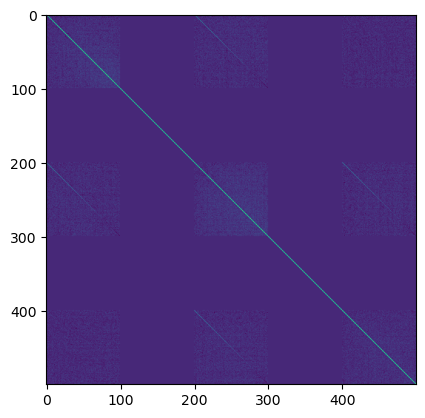

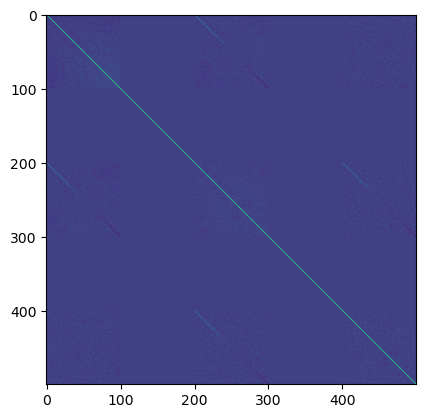

[0.0025 0.0075 0.0125 0.0175 0.0225 0.0275 0.0325 0.0375 0.0425 0.0475
 0.0525 0.0575 0.0625 0.0675 0.0725 0.0775 0.0825 0.0875 0.0925 0.0975
 0.1025 0.1075 0.1125 0.1175 0.1225 0.1275 0.1325 0.1375 0.1425 0.1475
 0.1525 0.1575 0.1625 0.1675 0.1725 0.1775 0.1825 0.1875 0.1925 0.1975
 0.2025 0.2075 0.2125 0.2175 0.2225 0.2275 0.2325 0.2375 0.2425 0.2475
 0.2525 0.2575 0.2625 0.2675 0.2725 0.2775 0.2825 0.2875 0.2925 0.2975
 0.3025 0.3075 0.3125 0.3175 0.3225 0.3275 0.3325 0.3375 0.3425 0.3475
 0.3525 0.3575 0.3625 0.3675 0.3725 0.3775 0.3825 0.3875 0.3925 0.3975
 0.4025 0.4075 0.4125 0.4175 0.4225 0.4275 0.4325 0.4375 0.4425 0.4475
 0.4525 0.4575 0.4625 0.4675 0.4725 0.4775 0.4825 0.4875 0.4925 0.4975]


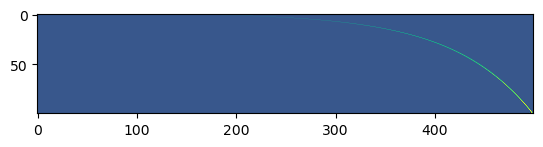

<_io.BufferedWriter name='../desi_kp4_abacus_cubicbox_pk_lrg.pkl'>


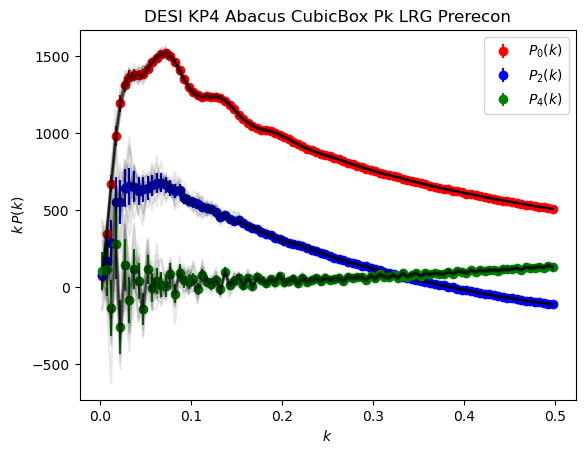

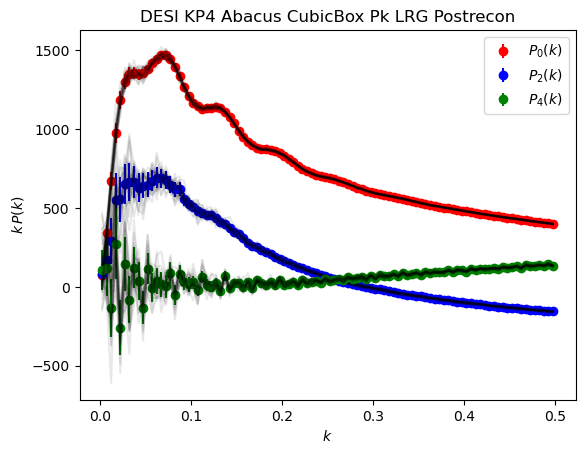

/tmp/ipykernel_1561224/1608519899.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  sin = pd.read_csv(loc+"/s.txt", comment="#", skiprows=0, delim_whitespace=True, header=None).to_numpy().T[0]
/tmp/ipykernel_1561224/1608519899.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ximat = [pd.read_csv(loc+f"/Xi_{ell}"+zname+".txt", comment="#", skiprows=0, delim_whitespace=True, header=None).to_numpy().T for ell in [0,2,4]]
/tmp/ipykernel_1561224/1608519899.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ximat = [pd.read_csv(loc+f"/Xi_{ell}"+zname+".txt", comment="#", skiprows=0, delim_whitespace=True, header=None).to_numpy().T for ell in [0,2,4]]
/tmp/ipykernel_1561224/1608519899.py:4: FutureW

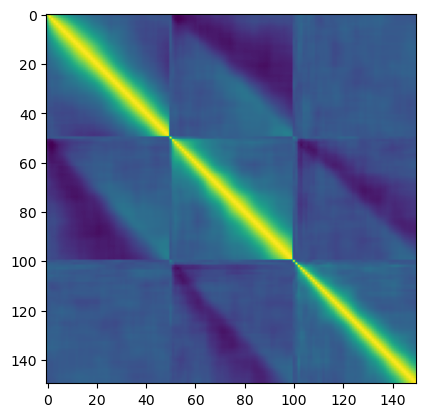

/tmp/ipykernel_1561224/1608519899.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  sin = pd.read_csv(loc+"/s.txt", comment="#", skiprows=0, delim_whitespace=True, header=None).to_numpy().T[0]
/tmp/ipykernel_1561224/1608519899.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ximat = [pd.read_csv(loc+f"/Xi_{ell}"+zname+".txt", comment="#", skiprows=0, delim_whitespace=True, header=None).to_numpy().T for ell in [0,2,4]]
/tmp/ipykernel_1561224/1608519899.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ximat = [pd.read_csv(loc+f"/Xi_{ell}"+zname+".txt", comment="#", skiprows=0, delim_whitespace=True, header=None).to_numpy().T for ell in [0,2,4]]
/tmp/ipykernel_1561224/1608519899.py:4: FutureW

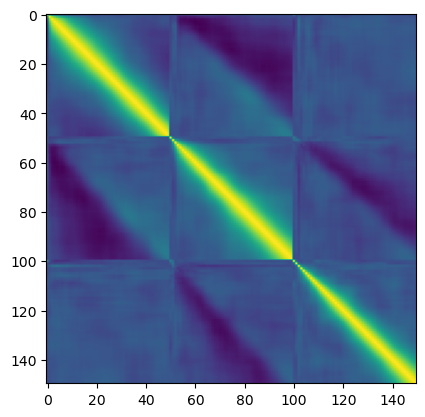

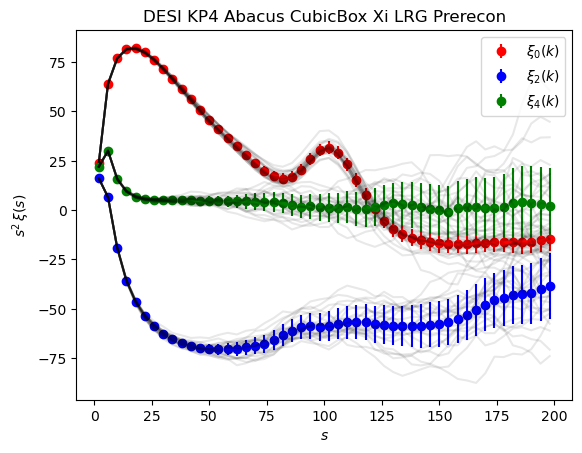

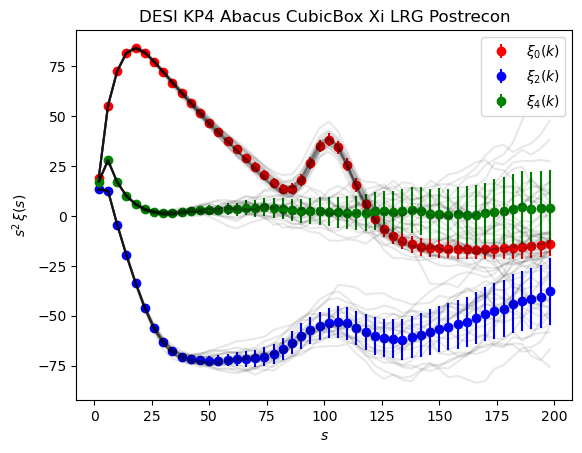

In [4]:
# Loop over tracers
path_abacus = "/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CubicBox/"
path_ezmock = "/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/EZmock/CubicBox/"

# Dictionary containing z for the tracers
reds = {"LRG": [0.8]}

tracer = "LRG"
for i, z in enumerate(reds[tracer]):
    
    # Power Spectrum
    pre_file = path_abacus + tracer + "/Pk/Pre/jmena/nmesh_512/dk0.005/"
    pre_cov_file = path_ezmock + tracer + "/Pk/jmena/nmesh_512/dk0.005/cov.txt"  # Uses the EZmock covariance
    post_file = path_abacus + tracer + "/Pk/Post/nadathur/fiducial_settings/dk0.005/"
    post_cov_file = path_ezmock + tracer + "/Pk/Post/forero/fiducial_settings/dk0.005/z0.800/"  # Uses the Postrecon EZmock covariance
    name = f"DESI KP4 Abacus CubicBox Pk " + tracer
    data = collect_pk_data(pre_file, post_file, pre_cov_file, post_cov_file, None, z, "", "", name, postformat="sn", postcovformat="dfs")
    plot_pk(data) # Plot the data to check things

    # Correlation Function
    pre_file = path_abacus + tracer + f"/Xi/Pre/jmena/"
    pre_cov_file = path_ezmock + tracer + f"/Xi/jmena/cov.txt"  # Uses the EZmock covariance
    post_file = path_abacus + tracer + "/Xi/Post/jmena/"
    post_cov_file = path_ezmock + tracer + "/Xi/Post/forero/fiducial_settings/z0.800/"  # Uses the Postrecon EZmock covariance
    name = f"DESI KP4 Abacus CubicBox Xi " + tracer
    data = collect_xi_data(pre_file, post_file, pre_cov_file, post_cov_file, z, "", "", name, postcovformat="dfsfdads")
    plot_xi(data) # Plot the data to check things
    
        

# CV mocks 

['/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CubicBox/LRG/Pk_CV/Pre/boryanah/LRG_snap20_ph024.gcat.Pk_nmesh1152.ecsv', '/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CubicBox/LRG/Pk_CV/Pre/boryanah/LRG_snap20_ph003.gcat.Pk_nmesh1152.ecsv', '/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CubicBox/LRG/Pk_CV/Pre/boryanah/LRG_snap20_ph019.gcat.Pk_nmesh1152.ecsv', '/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CubicBox/LRG/Pk_CV/Pre/boryanah/LRG_snap20_ph005.gcat.Pk_nmesh1152.ecsv', '/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CubicBox/LRG/Pk_CV/Pre/boryanah/LRG_snap20_ph020.gcat.Pk_nmesh1152.ecsv', '/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CubicBox/LRG/Pk_CV/Pre/boryanah/LRG_snap20_ph016.gcat.Pk_nmesh1152.ecsv', '/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CubicBox/LRG/Pk_CV/Pre/boryanah/LRG_snap20_ph000.gcat.Pk_nmesh1152.ecsv', '/global/cfs/cdirs/desi/co

/tmp/ipykernel_1561224/3387635472.py:277: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  cov_input = pd.read_csv(covfile, comment="#", delim_whitespace=True, header=None).to_numpy()


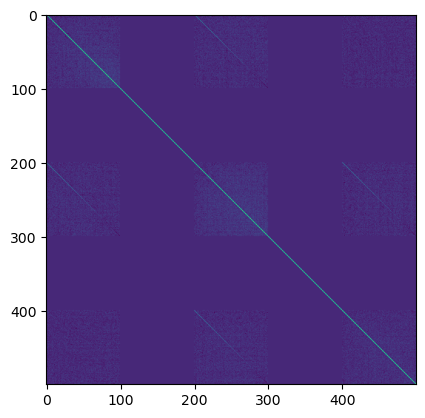

['/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CubicBox/LRG/Pk_CV/Post/boryanah/LRG_snap20_ph022.gcat_shift_MultiGrid_mesh512_smooth10_recsym_f0.838_b1.99_randoms_20X.Pk_nmesh1152.ecsv', '/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CubicBox/LRG/Pk_CV/Post/boryanah/LRG_snap20_ph000.gcat_shift_MultiGrid_mesh512_smooth10_recsym_f0.838_b1.99_randoms_20X.Pk_nmesh1152.ecsv', '/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CubicBox/LRG/Pk_CV/Post/boryanah/LRG_snap20_ph020.gcat_shift_MultiGrid_mesh512_smooth10_recsym_f0.838_b1.99_randoms_20X.Pk_nmesh1152.ecsv', '/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CubicBox/LRG/Pk_CV/Post/boryanah/LRG_snap20_ph010.gcat_shift_MultiGrid_mesh512_smooth10_recsym_f0.838_b1.99_randoms_20X.Pk_nmesh1152.ecsv', '/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CubicBox/LRG/Pk_CV/Post/boryanah/LRG_snap20_ph023.gcat_shift_MultiGrid_mesh512_smooth10_recsym_f0.838_b1.99_random

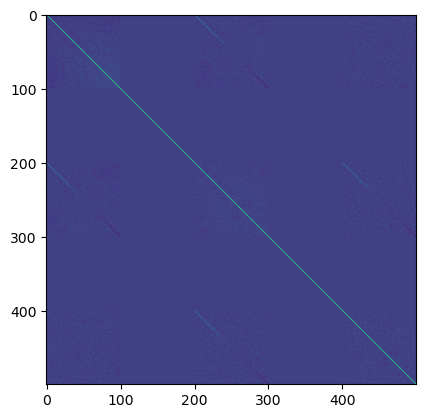

[0.0025 0.0075 0.0125 0.0175 0.0225 0.0275 0.0325 0.0375 0.0425 0.0475
 0.0525 0.0575 0.0625 0.0675 0.0725 0.0775 0.0825 0.0875 0.0925 0.0975
 0.1025 0.1075 0.1125 0.1175 0.1225 0.1275 0.1325 0.1375 0.1425 0.1475
 0.1525 0.1575 0.1625 0.1675 0.1725 0.1775 0.1825 0.1875 0.1925 0.1975
 0.2025 0.2075 0.2125 0.2175 0.2225 0.2275 0.2325 0.2375 0.2425 0.2475
 0.2525 0.2575 0.2625 0.2675 0.2725 0.2775 0.2825 0.2875 0.2925 0.2975
 0.3025 0.3075 0.3125 0.3175 0.3225 0.3275 0.3325 0.3375 0.3425 0.3475
 0.3525 0.3575 0.3625 0.3675 0.3725 0.3775 0.3825 0.3875 0.3925 0.3975
 0.4025 0.4075 0.4125 0.4175 0.4225 0.4275 0.4325 0.4375 0.4425 0.4475
 0.4525 0.4575 0.4625 0.4675 0.4725 0.4775 0.4825 0.4875 0.4925 0.4975]


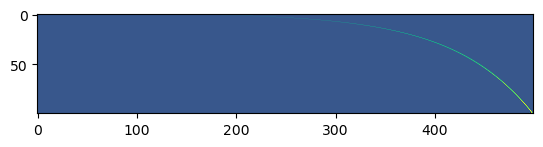

<_io.BufferedWriter name='../desi_kp4_abacus_cubicbox_cv_pk_lrg.pkl'>


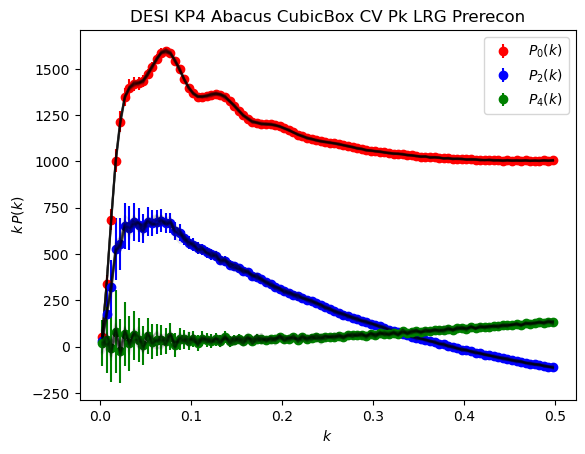

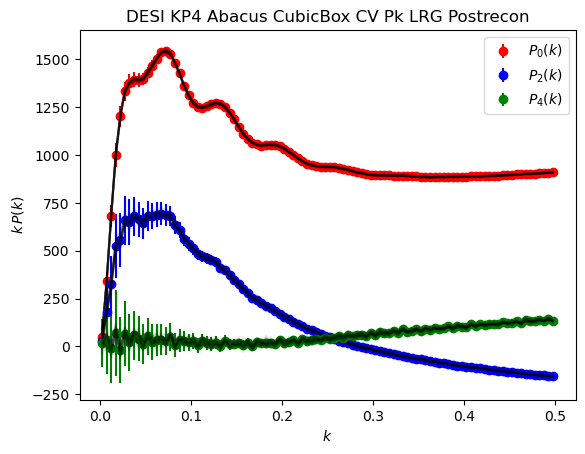

In [5]:
# Boryana's control variate simulations
path_abacus = "/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CubicBox/"
path_ezmock = "/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/EZmock/CubicBox/"

# Dictionary containing z for the tracers
reds = {"LRG": [0.8]}

for tracer in ["LRG"]:
    for i, z in enumerate(reds[tracer]):
    
        # Power Spectrum
        pre_file = path_abacus + tracer + "/Pk_CV/Pre/boryanah/"
        pre_cov_file = path_ezmock + tracer + "/Pk/jmena/nmesh_512/dk0.005/cov.txt"  # Uses the normal (not CV) EZmock covariance
        post_file = path_abacus + tracer + "/Pk_CV/Post/boryanah/"
        post_cov_file = path_ezmock + tracer + "/Pk/Post/forero/fiducial_settings/dk0.005/z0.800/"  # Uses the Postrecon EZmock covariance
        name = f"DESI KP4 Abacus CubicBox CV Pk " + tracer
        data = collect_pk_data(pre_file, post_file, pre_cov_file, post_cov_file, None, z, "", "", name, preformat="bh", postformat="bh", postcovformat="dfs")
        plot_pk(data) # Plot the data to check things

        # Correlation Function
        # pre_file = path_abacus + tracer + f"/Xi_CV/Pre/boryanah/"
        # pre_cov_file = path_ezmock + tracer + f"/Xi/jmena/cov.txt"  # Uses the EZmock covariance
        # post_file = path_abacus + tracer + "/Xi_CV/Post/boryanah/"
        # post_cov_file = path_ezmock + tracer + "/Xi/Post/forero/fiducial_settings/z0.800/"  # Uses the Postrecon EZmock covariance
        # name = f"DESI KP4 Abacus CubicBox CV Xi " + tracer
        # data = collect_xi_data(pre_file, post_file, pre_cov_file, post_cov_file, z, "", "", name, postcovformat="dfs", preformat='pm')
        # plot_xi(data) # Plot the data to check things